# Worked example of spectral unmixing: Claisen-Schmidt condensation reaction.

This tutorial demonstrates the worked example of a workflow for analyzing chemical reaction outcomes using UV-Vis spectral unmixing. We'll analyze a Claisen-Schmidt condensation reaction that produces methoxychalcone from anisaldehyde and acetophenone.

## Overview

Spectral unmixing is a technique that decomposes the absorption spectrum of a complex mixture into contributions from individual chemical components. This allows us to determine the concentration of each component in the mixture.

The process involves two main steps:
1. **Calibration**: Measure reference spectra of pure components at known concentrations
2. **Unmixing**: Fit a linear combination of reference spectra to unknown mixture spectra, then convert the best-fit scaling coefficients to concentrations using the calibration information from Step 1

## Scope and limitations of this worked example (notebook)

This tutorial demonstrates the core methodology using simplified examples. The rest of our code repository provides more sophisticated capabilities that are not covered here.

### What this notebook covers:
- Single-spectrum unmixing of a three-component crude mixture of the Claisen-Schmidt condensation reaction illustrated in Figure 1c,d of the accompanying article.
- Simple calibration that takes measured spectrum of pure compound at a certain concentration as the reference.
- Advanced background modeling: background (baseline) variation is modeled as a sum of three terms: constant offset, linear (in wavelength) drift term, and two scaled principal components identified separately by Principal Component Analysis (PCA) of multiple measurements of the spectra of pure solvent

### Advanced calibration features not shown in this notebook:
- **Stitching of reference spectrum**: Stitching spectra from multiple concentrations for improving the dynamic range. Useful for multispectral unmixing.
- **Adaptive noise reduction of reference spectrum**: Savitzky-Golay smoothing in low-intensity regions of reference spectrum, weighted by absorbance levels  
- **Loading external reference spectrum**: Loading of reference spectrum from high-precision data produced with Agilent Cary spectrophotometer
- **Advanced quality control during calibration**: Masking of regions that may have instrumental artefacts and deviations from linearity of Beer-Lambert law 

### Advanced unmixing features not shown in this notebook:
- **Advanced quality control of the raw spectra**: Masking of regions that may have instrumental artefacts and deviations from linearity of Beer-Lambert law
- **Multi-spectrum unmixing**: The same "parent" mixture is diluted by different factors and the collected spectra of these diluted samples are used simultaneously for unmixing and understanding the concentration of the substance in the "parent" mixture.
- **Stoichiometric constraints**: Enforcement of chemical mass balance to prevent unphysical solutions
- **Instrumental uncertainty modeling**: Model fitting with heteroscedactic instrumental errors. In separate measurements, the dependence of absorbance errors of a specific instrument on the wavelength and the absorbance level is determined, and this information is used to produce heteroscedactic errors for weighted fitting procedure.
- **Correcting for wavelength offsets**: Accounting for miniscule wavelength shifts from one measurement to the next. This is an instrumental artifact of NanoDrop spectrophotometer. 

### Instrument-related features not shown in this notebook:
- **Automatic treatment of the variable spectral range of NanoDrop spectrophotometer**: In the output files of this instrument, the spectral range varies from sample to sample, depending on the spectrum of the sample at hand. Because of this, some of the raw spectra contain data from 190 nm to 850 nm, while other have spectral range from 220 nm to 600 nm. In our code repository, the raw spectra are automatically cropped to 220-600 nm range. This automatic cropping procedure is omitted from this notebook so as not to complicate the code. The input spectral data files used in this example are already cropped to 220-600 nm range. 



---

# Chapter 1: Step-by-Step Spectral Unmixing

## Input Data Structure

Our analysis requires two input files with matching base names:

### Spectral Data File (.csv)
Contains UV-Vis absorption spectra with wavelengths in the first column and sample measurements in numbered columns:

```
,0,1,2,3,4,7,5,6,9,8,11,10,13,12,15,14
220,0.068,0.102,0.194,0.281,0.015,0.353,0.108,0.187,0.673,0.555,0.049,0.033,0.114,0.078,0.02,0.139
221,0.068,0.105,0.2,0.286,0.015,0.338,0.104,0.179,0.631,0.522,0.054,0.035,0.13,0.089,0.017,0.16
222,0.066,0.105,0.203,0.291,0.012,0.324,0.101,0.173,0.593,0.494,0.06,0.037,0.149,0.102,0.018,0.182
```

### Metadata File (.txt)
Contains sample information linking column numbers to chemical identities and concentrations:

```
# nanodrop_col_name,substance,dilution_factor,solvent,concentration
# 0,methoxychalcone,1,ethanol,0.00005
# 1,methoxychalcone,1,ethanol,0.0001
# 2,methoxychalcone,1,ethanol,0.0002
# 3,methoxychalcone,1,ethanol,0.0003
# 5,anisaldehyde,1,ethanol,0.00005
# 6,anisaldehyde,1,ethanol,0.0001
# 7,anisaldehyde,1,ethanol,0.0002
# 8,anisaldehyde,1,ethanol,0.0003
# 9,anisaldehyde,1,ethanol,0.0004
# 10,acetophenone,1,ethanol,0.00005
# 11,acetophenone,1,ethanol,0.0001
# 12,acetophenone,1,ethanol,0.0002
# 13,acetophenone,1,ethanol,0.0003
# 14,acetophenone,1,ethanol,0.0004
# 15,solvent_ethanol,1,ethanol,0
```

## Importing required libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

## Data Loading and Preprocessing

The following code cell loads the spectral data and metadata, renames columns, and prepares the wavelength array.

In [62]:
# Load the spectral data into dataframe
calibration_source_filename = 'data/calibration_of_all_components'
nanodrop_df = pd.read_csv(calibration_source_filename + '.csv')
# rename first column to "wavelength" and make it float type
nanodrop_df = nanodrop_df.rename(columns={nanodrop_df.columns[0]: "wavelength"})
nanodrop_df["wavelength"] = nanodrop_df["wavelength"].astype(float)

# make an array of wavelengths
wavelengths = nanodrop_df['wavelength'].to_numpy()
wavelength_indices = np.arange(wavelengths.shape[0])

# Load the last file to pandas dataframe and change type of the `nanodrop_col_name` column to string.
all_calibrants_df = pd.read_csv(calibration_source_filename + '.txt')
all_calibrants_df['nanodrop_col_name'] = all_calibrants_df['nanodrop_col_name'].astype(str)
concentration_column_name = 'concentration'

## Background Spectrum Subtraction

The background spectrum represents the solvent-only measurement (zero concentration). We subtract this from all measurements to isolate the contribution from chemical components. This step is crucial because it removes the solvent's optical contribution, leaving only the signal from the dissolved chemical species.

In [63]:
# identify the background spectrum -- it is one with zero concentration
col_name_with_background = all_calibrants_df.loc[all_calibrants_df[concentration_column_name] == 0].iloc[0][
    'nanodrop_col_name']
absorbances = nanodrop_df[col_name_with_background].to_numpy()
bkg_spectrum = np.array([wavelengths, absorbances]).T

# subtract the absorbances of background spectrum from all the rows of nanodrop_df except the furst one
for col in nanodrop_df.columns[1:]:
    nanodrop_df[col] = nanodrop_df[col] - nanodrop_df[col_name_with_background]

## Calibration Process

For each chemical component, we need to establish the relationship between spectral scaling coefficients and concentrations. This involves:

1. Selecting a reference spectrum at a known concentration
2. Fitting the reference spectrum to spectra at other concentrations
3. Building a coefficient-to-concentration relationship

### Calibration for Methoxychalcone

We start by isolating the data for methoxychalcone and selecting a reference concentration. The reference concentration should be high enough to provide good signal-to-noise ratio but not so high that it suffers from instrumental artifacts and non-linear deviation from the Beer-Lambert law.

In [64]:
calibrant_shortname = 'methoxychalcone'
ref_concentration = 0.0002
one_calibrant_df = all_calibrants_df[all_calibrants_df['substance'] == calibrant_shortname]

Now we extract the reference spectrum at our chosen concentration and prepare it for use as a template. We subtract the mean of the last 100 points to remove any baseline offset, making the plots clearer without affecting the fitting (since vertical offset is a fitted parameter anyway).

In [65]:
target_concentration = ref_concentration
df_row_with_target_concentration = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
ref_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
ref_spectrum -= np.mean(ref_spectrum[-100:])

reference_interpolator = interpolate.interp1d(wavelength_indices, ref_spectrum, fill_value='extrapolate')

### Demonstrating the Scaling Process

Let's demonstrate how we scale the reference spectrum to match a spectrum at a different concentration: `target_concentration = 0.00005`. This process is the core of spectral calibration - we find the scaling factor needed to transform our reference spectrum into the target spectrum.

We'll use a simple linear model where the target spectrum equals a scaled version of the reference spectrum plus a baseline offset. This accounts for both the concentration-dependent scaling (Beer-Lambert law) and any small instrumental differences between measurements.

#### The Linear Scaling Model

The model function implements a simple linear relationship:
**target_spectrum = a × reference_spectrum + b**

Where:
- **a** is the scaling coefficient (proportional to the concentration ratio)
- **b** is a baseline offset (accounts for instrumental variations)
- **reference_spectrum** is evaluated at the provided wavelength indices using interpolation

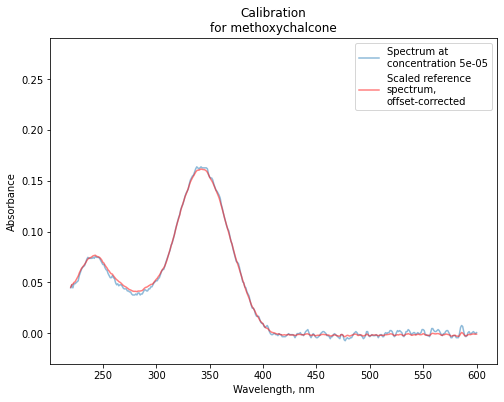

In [66]:
target_concentration = 0.00005

df_row_here = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]

df_row_with_target_concentration = \
    one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
target_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
target_spectrum -= np.mean(target_spectrum[-100:])

def model_function(xs, a, b):
    return a * reference_interpolator(xs) + b


initial_guess_of_scaling_coefficient = target_concentration / ref_concentration
initial_guess_of_offset = 0
# the scaling coefficient is bound by zero from below; other bounds are not set
popt, pcov = curve_fit(model_function, wavelength_indices, target_spectrum,
                       p0=(initial_guess_of_scaling_coefficient, initial_guess_of_offset),
                       bounds=([-1e-10, -np.inf], [np.inf, np.inf]))

# errors of the fitted parameters
perr = np.sqrt(np.diag(pcov))

# scaling coefficient (slope) is the first parameter of the fitted function
slope = popt[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(wavelengths, target_spectrum, label=f'Spectrum at\nconcentration {target_concentration}', color='C0', alpha=0.5)
ax.plot(wavelengths, model_function(wavelength_indices, *popt), color='r',
        label='Scaled reference\nspectrum,\noffset-corrected', alpha=0.5)
ax.set_ylim(-0.03, np.max((model_function(wavelength_indices, *popt))) * 1.8)
# ax.set_title(
#     f"Scaling the reference spectrum to match the spectrum at concentration {concentration}")
ax.legend()
ax.set_title(f'Calibration\nfor {calibrant_shortname}')
ax.set_xlabel('Wavelength, nm')
ax.set_ylabel('Absorbance')

plt.show()

### Building the Complete Calibration Curve

Now we'll repeat this in a loop across all concentrations to build the complete calibration curve. This establishes the quantitative relationship between scaling coefficients and actual concentrations, which we'll use later for unknown mixture analysis.

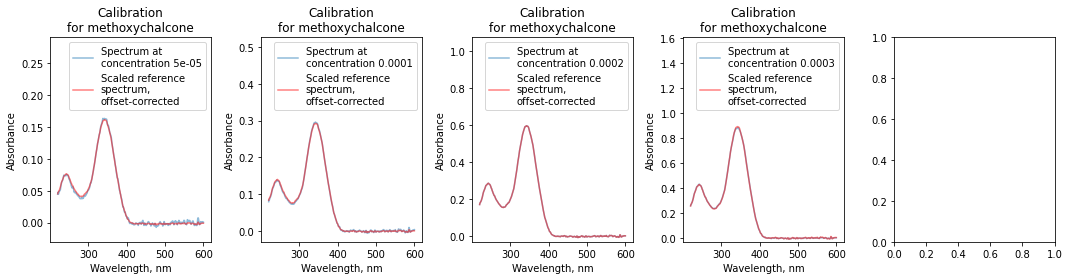

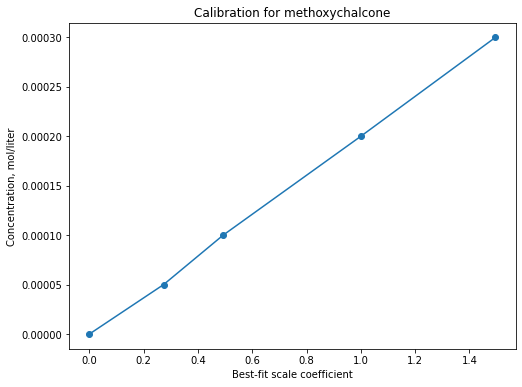

In [67]:
# sort the concentrations in ascending order
concentrations = sorted([0] + one_calibrant_df[concentration_column_name].to_list())

coeffs = []
spectra = []

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for concentration in concentrations:
    if concentration == 0:
        coeffs.append(0)
        continue

    df_row_here = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == concentration].iloc[0]

    target_concentration = concentration
    df_row_with_target_concentration = \
    one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
    target_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
    target_spectrum -= np.mean(target_spectrum[-100:])
    spectra.append(np.copy(target_spectrum))

    def model_function(xs, a, b):
        return a * reference_interpolator(xs) + b

    initial_guess_of_scaling_coefficient = concentration / ref_concentration
    initial_guess_of_offset = 0
    # the scaling coefficient is bound by zero from below; other bounds are not set
    popt, pcov = curve_fit(model_function, wavelength_indices, target_spectrum,
                           p0=(initial_guess_of_scaling_coefficient, initial_guess_of_offset),
                           bounds=([-1e-10, -np.inf], [np.inf, np.inf]))

    perr = np.sqrt(np.diag(pcov))
    slope = popt[0]
    slope_error = perr[0]
    coeffs.append(slope)

    ax = axes[concentrations.index(concentration)-1]
    ax.plot(wavelengths, target_spectrum, label=f'Spectrum at\nconcentration {concentration}', color='C0', alpha=0.5)
    ax.plot(wavelengths, model_function(wavelength_indices, *popt), color='r',
            label='Scaled reference\nspectrum,\noffset-corrected', alpha=0.5)
    ax.set_ylim(-0.03, np.max((model_function(wavelength_indices, *popt))) * 1.8)
    # ax.set_title(
    #     f"Scaling the reference spectrum to match the spectrum at concentration {concentration}")
    ax.legend()
    ax.set_title(f'Calibration\nfor {calibrant_shortname}')
    ax.set_xlabel('Wavelength, nm')
    ax.set_ylabel('Absorbance')

plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(8, 6))
plt.plot(coeffs, concentrations, 'o-')
plt.xlabel('Best-fit scale coefficient')
plt.ylabel('Concentration, mol/liter')
plt.title(f'Calibration for {calibrant_shortname}')
plt.show()

We store the calibration results for later use in spectral unmixing. The reference interpolator allows us to evaluate the reference spectrum at any wavelength, while the coefficient-to-concentration interpolator converts fitted scaling factors into actual concentrations.

In [68]:
calibrants = list()
calibrants.append({'reference_interpolator': interpolate.interp1d(wavelength_indices, ref_spectrum,
                                                                   fill_value='extrapolate'),
                   'coeff_to_concentration_interpolator': interpolate.interp1d(coeffs, concentrations,
                                                                           fill_value='extrapolate')})

### Calibration for Anisaldehyde

We repeat exactly the same process for anisaldehyde:

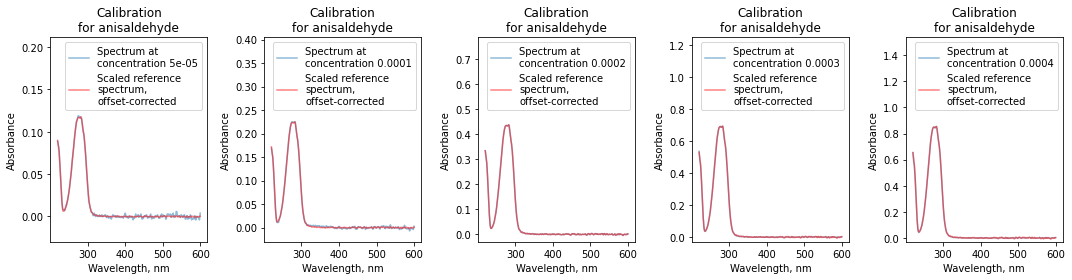

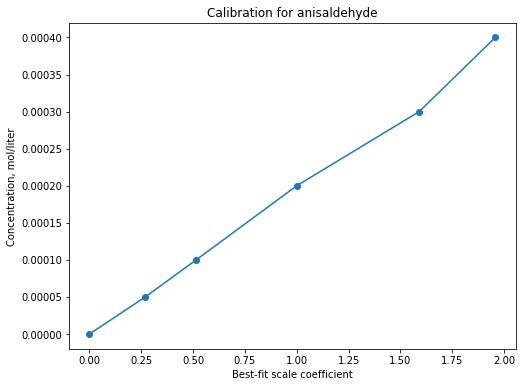

In [69]:
calibrant_shortname = 'anisaldehyde'
ref_concentration = 0.0002 # reference concentration for methoxychalcone
one_calibrant_df = all_calibrants_df[all_calibrants_df['substance'] == calibrant_shortname]

# identify the spectrum with reference concentrations: column of nanodrop_df with the reference concentration in the
# concentration column
target_concentration = ref_concentration
df_row_with_target_concentration = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
ref_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
# subtract the mean of the last 100 points from the reference spectrum from the reference spectrum
# This makes the plots less confusing, but does not affect the fitting, because vertical offset is one of free parameters anyway,
ref_spectrum -= np.mean(ref_spectrum[-100:])

# make a linear interpolator for the reference spectrum
# this is a function that can be evaluated at any wavelength index
reference_interpolator = interpolate.interp1d(wavelength_indices, ref_spectrum, fill_value='extrapolate')

# sort the concentrations in ascending order
concentrations = sorted([0] + one_calibrant_df[concentration_column_name].to_list())

coeffs = []
spectra = []

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for concentration in concentrations:
    if concentration == 0:
        coeffs.append(0)
        continue

    df_row_here = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == concentration].iloc[0]

    target_concentration = concentration
    df_row_with_target_concentration = \
    one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
    target_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
    target_spectrum -= np.mean(target_spectrum[-100:])
    spectra.append(np.copy(target_spectrum))

    def model_function(xs, a, b):
        return a * reference_interpolator(xs) + b

    initial_guess_of_scaling_coefficient = concentration / ref_concentration
    initial_guess_of_offset = 0
    # the scaling coefficient is bound by zero from below; other bounds are not set
    popt, pcov = curve_fit(model_function, wavelength_indices, target_spectrum,
                           p0=(initial_guess_of_scaling_coefficient, initial_guess_of_offset),
                           bounds=([-1e-10, -np.inf], [np.inf, np.inf]))

    perr = np.sqrt(np.diag(pcov))
    slope = popt[0]
    slope_error = perr[0]
    coeffs.append(slope)

    ax = axes[concentrations.index(concentration)-1]
    ax.plot(wavelengths, target_spectrum, label=f'Spectrum at\nconcentration {concentration}', color='C0', alpha=0.5)
    ax.plot(wavelengths, model_function(wavelength_indices, *popt), color='r',
            label='Scaled reference\nspectrum,\noffset-corrected', alpha=0.5)
    ax.set_ylim(-0.03, np.max((model_function(wavelength_indices, *popt))) * 1.8)
    ax.legend()
    ax.set_title(f'Calibration\nfor {calibrant_shortname}')
    ax.set_xlabel('Wavelength, nm')
    ax.set_ylabel('Absorbance')

plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(8, 6))
plt.plot(coeffs, concentrations, 'o-')
plt.xlabel('Best-fit scale coefficient')
plt.ylabel('Concentration, mol/liter')
plt.title(f'Calibration for {calibrant_shortname}')
plt.show()

calibrants.append({'reference_interpolator': interpolate.interp1d(wavelength_indices, ref_spectrum,
                                                                   fill_value='extrapolate'),
                   'coeff_to_concentration_interpolator': interpolate.interp1d(coeffs, concentrations,
                                                                           fill_value='extrapolate')})

### Calibration for Acetophenone

Finally, we calibrate acetophenone in the same way. This completes our calibration dataset, which will be used for unmixing unknown reaction mixtures.

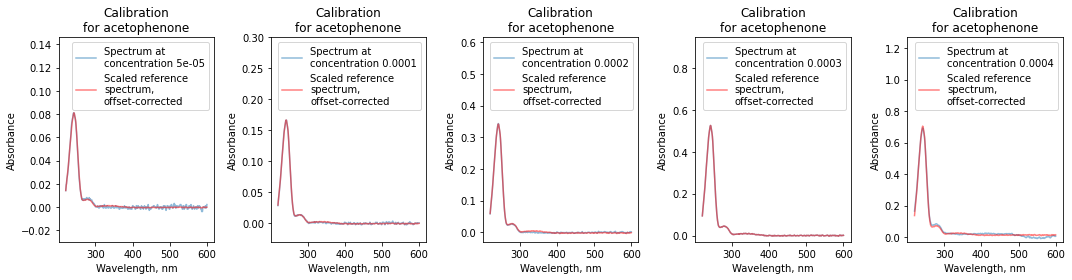

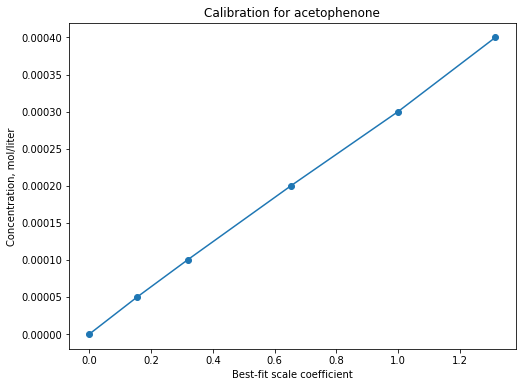

In [70]:
calibrant_shortname = 'acetophenone'
ref_concentration = 0.0003 # reference concentration for methoxychalcone
one_calibrant_df = all_calibrants_df[all_calibrants_df['substance'] == calibrant_shortname]

# identify the spectrum with reference concentrations: column of nanodrop_df with the reference concentration in the
# concentration column
target_concentration = ref_concentration
df_row_with_target_concentration = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
ref_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
# subtract the mean of the last 100 points from the reference spectrum from the reference spectrum
# This makes the plots less confusing, but does not affect the fitting, because vertical offset is one of free parameters anyway,
ref_spectrum -= np.mean(ref_spectrum[-100:])

# make a linear interpolator for the reference spectrum
# this is a function that can be evaluated at any wavelength index
reference_interpolator = interpolate.interp1d(wavelength_indices, ref_spectrum, fill_value='extrapolate')

# sort the concentrations in ascending order
concentrations = sorted([0] + one_calibrant_df[concentration_column_name].to_list())

coeffs = []
spectra = []

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for concentration in concentrations:
    if concentration == 0:
        coeffs.append(0)
        continue

    df_row_here = one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == concentration].iloc[0]

    target_concentration = concentration
    df_row_with_target_concentration = \
    one_calibrant_df.loc[one_calibrant_df[concentration_column_name] == target_concentration].iloc[0]
    target_spectrum = nanodrop_df[df_row_with_target_concentration['nanodrop_col_name']].to_numpy()
    target_spectrum -= np.mean(target_spectrum[-100:])
    spectra.append(np.copy(target_spectrum))

    def model_function(xs, a, b):
        return a * reference_interpolator(xs) + b

    initial_guess_of_scaling_coefficient = concentration / ref_concentration
    initial_guess_of_offset = 0
    # the scaling coefficient is bound by zero from below; other bounds are not set
    popt, pcov = curve_fit(model_function, wavelength_indices, target_spectrum,
                           p0=(initial_guess_of_scaling_coefficient, initial_guess_of_offset),
                           bounds=([-1e-10, -np.inf], [np.inf, np.inf]))

    perr = np.sqrt(np.diag(pcov))
    slope = popt[0]
    slope_error = perr[0]
    coeffs.append(slope)

    ax = axes[concentrations.index(concentration)-1]
    ax.plot(wavelengths, target_spectrum, label=f'Spectrum at\nconcentration {concentration}', color='C0', alpha=0.5)
    ax.plot(wavelengths, model_function(wavelength_indices, *popt), color='r',
            label='Scaled reference\nspectrum,\noffset-corrected', alpha=0.5)
    ax.set_ylim(-0.03, np.max((model_function(wavelength_indices, *popt))) * 1.8)
    ax.legend()
    ax.set_title(f'Calibration\nfor {calibrant_shortname}')
    ax.set_xlabel('Wavelength, nm')
    ax.set_ylabel('Absorbance')

plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(8, 6))
plt.plot(coeffs, concentrations, 'o-')
plt.xlabel('Best-fit scale coefficient')
plt.ylabel('Concentration, mol/liter')
plt.title(f'Calibration for {calibrant_shortname}')
plt.show()

calibrants.append({'reference_interpolator': interpolate.interp1d(wavelength_indices, ref_spectrum,
                                                                   fill_value='extrapolate'),
                   'coeff_to_concentration_interpolator': interpolate.interp1d(coeffs, concentrations,
                                                                           fill_value='extrapolate')})

## Deconstructing the variation of background (baseline) with Principal Component Analysis (PCA)

We load 54 spectra of pure ethanol, which were measured by NanoDrop spectrophotometer in the course of the calibration procedure. These spectra are used to build a model of the background variation that is not accounted for by the simple baseline subtraction. The grey semitransparent spectra in the figure below show the 54 loaded spectra. The principal components of this variation are shown as blue and orange lines. Dashed curve of same colors show these components after smoothing with Savitzky-Golay filter. The purpose of applying Savitzky-Golay filter is to reduce the remaining noise, which would otherwise harm the spectral unmixing procedure. 

These smoothed components are saved to the `data/ethanol_background_model/component_0.npy` and `data/ethanol_background_model/component_1.npy` files.


Principle component #1 explains 88.94% of the variance in the background spectra
Principle component #2 explains 3.70% of the variance in the background spectra


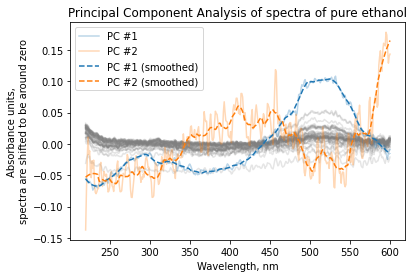

In [71]:
from sklearn.decomposition import PCA as pca
from scipy.signal import savgol_filter

# load CSV with 54 spectra of pure ethanol into a dataframe
pure_background_spectra_df = pd.read_csv('data/ethanol_background_model/spectra_of_pure_ethanol_54_times.csv')
# spectra are columns except the first column
spectra = pure_background_spectra_df.iloc[:, 1:].to_numpy().T

# plot all the 54 spectra
for spectrum in spectra:
    plt.plot(wavelengths, spectrum, alpha=0.2, color='grey')

# Principal component analysis of the background spectra
nc = 2 # number of components requested
pca1 = pca(n_components=nc)
nfeat1 = spectra
nfeat1 = [x - np.mean(x) for x in nfeat1]
X1 = pca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_
for i, var in enumerate(expl_var_1):
    print(f'Principle component #{i+1} explains {var:.2%} of the variance in the background spectra')
sv = X1.components_.T

# plotting the principal components
colors = ['C0', 'C1', 'C2']
for i in range(nc):
    plt.plot(wavelengths, sv[:, i], label=f'PC #{i+1}', color=colors[i], alpha=0.3)

# Smooth the components, plot the smoothed result, and save smoothed components to files
for i in range(nc):
    smoothed_component = savgol_filter(sv[:, i], polyorder=2, window_length=31)
    plt.plot(wavelengths, smoothed_component, linestyle='--', label=f'PC #{i+1} (smoothed)', color=colors[i])
    np.save(f'data/ethanol_background_model/component_{i}.npy', smoothed_component)

# Add labels and legend to the plot
plt.title('Principal Component Analysis of spectra of pure ethanol')
plt.xlabel('Wavelength, nm')
plt.ylabel('Absorbance units,\nspectra are shifted to be around zero')
plt.legend()
plt.show()

## Spectral Unmixing of Crude Reaction Mixture

Now we have all the calibration data needed to analyze an unknown mixture. The unmixing process involves fitting a linear combination of reference spectra to the measured spectrum.

### Configuration Parameters

Before proceeding with the unmixing, we need to set several important parameters that control how the model behaves:

- **`ignore_pca_bkg`**: Controls whether to include Principal Component Analysis (PCA) background components in the fit. PCA components capture systematic background variations that aren't accounted for by simple baseline corrections.
- **`use_line`**: Determines whether to include a linear baseline drift term in addition to the constant baseline offset. This accounts for wavelength-dependent instrumental drift.
- **`default_limit_of_magnitude_of_weights_for_background_pca_components`**: Sets the maximum allowed magnitude for PCA background component weights.

You may experiment with these parameters as you see fit.

In [72]:
ignore_pca_bkg = False
use_line = True
default_limit_of_magnitude_of_weights_for_background_pca_components = np.inf

calibrant_shortnames = ['methoxychalcone', 'anisaldehyde', 'acetophenone']

### Loading the Mixture Spectrum and Background Components

We load the crude mixture spectrum from the file `data/spectra_of_crude_mixtures.csv`. For illustration, we will unmix the spectrum from the column with sample ID '0'. We copy this spectrum into the `target_spectrum` variable.

In [73]:
crude_mixtures_df = pd.read_csv('data/spectra_of_crude_mixtures.csv')
# rename first column to "wavelength" and make it float type
crude_mixtures_df = crude_mixtures_df.rename(columns={crude_mixtures_df.columns[0]: "wavelength"})
crude_mixtures_df["wavelength"] = crude_mixtures_df["wavelength"].astype(float)

sample_id = '0'
# load target spectrum
target_spectrum_raw = crude_mixtures_df[sample_id].to_numpy()
# subtract the background spectrum previously determined
target_spectrum = target_spectrum_raw - bkg_spectrum[:, 1]

Next, we load and the pre-calculated PCA background components. The PCA components were derived from analyzing multiple background measurements to identify common patterns of systematic variation.

In [74]:
# Load the PCA components of the background spectrum, which were previously calculated and saved.
background_model_folder = 'data/ethanol_background_model/'
background_interpolators = [interpolate.interp1d(wavelength_indices,
                                                 np.load(background_model_folder + f'component_{i}.npy'),
                                                 fill_value='extrapolate')
                            for i in range(2)]

### The Spectral Unmixing Model

The central part of spectral unmixing is the linear model that describes how the measured spectrum arises from individual component contributions. Our model in this example accounts for:

- **Spectra of substances present in the mixture**: Scaled reference spectra of each chemical component
- **Background variations**: The background variation is modeled as a sum of three terms: constant offset, linear (in wavelength) drift term, and two scaled principal components identified earlier by Principal Component Analysis (PCA) of multiple measurements of the spectra of pure solvent.

Since it takes wavelength indices as the first argument, the mathematical formulation of this implementation is: 

**A(i) = Σⱼ aⱼ Rⱼ(i) + b₀ + b₁·i + Σₖ wₖ Bₖ(i)**

Where:
- A(i) is the predicted absorbance at wavelength index i
- aⱼ is the scaling coefficient for calibrant j (proportional to concentration)
- Rⱼ(i) is the reference spectrum of calibrant j at wavelength index i  
- b₀ is the constant baseline offset (instrumental drift)
- b₁ is the linear baseline slope (wavelength-dependent drift)
- wₖ is the weight for PCA background component k
- Bₖ(i) is the value (at wavelength index i) of the k-th component produced by PCA of many background spectra

The argument structure (`*args`) of the `model_function(*args)` is as follows. The first argument is the wavelength indices at which the model spectrum should be evaluated, followed by the scaling coefficients for each calibrant's reference spectrum, and finally the baseline and PCA background parameters. It is implemented like this in order to be compatible with an arbitrary number of calibrants - this necessitates that the number of scaling coefficients is variable.


In [75]:
def model_function(*args):
    # Extract wavelength indices, at which the model spectrum should be evaluated
    wavelength_indices = args[0]

    # Extract fitted baseline and background parameters (last 4 fitted parameters)
    baseline_offset, linear_slope, pca1_weight, pca2_weight = args[-4:]

    # Extract fitted scaling coefficients for each calibrant (middle fitted parameters)
    calibrant_coefficients = args[1:-4]

    # Build predicted spectrum as linear combination of components
    predicted_spectrum = (
        # Core Beer-Lambert law: sum of scaled reference spectra
            sum([calibrant_coefficients[i] * calibrants[i]['reference_interpolator'](wavelength_indices)
                 for i in range(len(calibrant_coefficients))]) +

            # Instrumental baseline correction: constant offset + linear drift
            baseline_offset + linear_slope * wavelength_indices +

            # Systematic background variations captured by PCA components
            pca1_weight * background_interpolators[0](wavelength_indices) +
            pca2_weight * background_interpolators[1](wavelength_indices)
    )

    return predicted_spectrum

### Setting Up the Optimization

We define initial parameter guesses and establish bounds for each parameter type. The bounds ensure physically meaningful results and help guide the optimization process.

In [76]:
# define the initial guess for the parameters
p0 = tuple([0.0005]*len(calibrant_shortnames) + [0] * 4)

# if use_line is False, will only fit the baseline offset. If True, will also add a baseline component linearly increasing with
# wavelength index. Slope is also a free parameter that is fitted.
if use_line:
    linebounds = [-np.inf, np.inf]
else:
    linebounds = [-1e-15, 1e-15]

# IF ignore_pca_bkg is True, the PCA background components are not fitted at all, and their weights are set to zero.
# In this implementation, this is achieved by setting the bounds for their weights to a very small values around zero.
if ignore_pca_bkg:
    bkg_comp_limit = 1e-12
else:
    bkg_comp_limit = default_limit_of_magnitude_of_weights_for_background_pca_components

### Parameter Bounds Explanation

The bounds serve important purposes in constraining the optimization:

- **Component coefficients**: Lower bound of -1e-20 (effectively zero) prevents negative concentrations, upper bound unlimited
- **Baseline offset**: Unlimited range to accommodate any constant instrumental offset
- **Linear slope**: Controlled by `use_line` parameter - either unlimited (if enabled) or constrained near zero (if disabled)
- **PCA background weights**: Controlled by `ignore_pca_bkg` parameter - either unlimited (if enabled) or constrained near zero (if disabled)

In [77]:
# Collect all the bounds for the parameters to be fitted into a form required by the `scipy.optimize.curve_fit` method.
bounds = ([-1e-20] * len(calibrant_shortnames) + [-np.inf, linebounds[0], -1 * bkg_comp_limit, -1 * bkg_comp_limit],
          [np.inf] * len(calibrant_shortnames) + [np.inf, linebounds[1], bkg_comp_limit, bkg_comp_limit])

### Optimizing the parameters by fitting the unmixing model

We call the `scipy.optimize.curve_fit` function to perform the optimization. This function finds the best-fitting parameters that minimize the difference between the measured target spectrum and the model spectrum generated by our `model_function`.
The best values of parameters are returned as `popt` array.

In [78]:
# perform the curve fitting to find the best values of parameters (returned as `popt` array)
popt, pcov = curve_fit(model_function, wavelength_indices, target_spectrum,
                       p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))  # errors of the best-fit parameters

### Converting best-fit scaling coefficients to concentrations of mixture components

The fitted scaling coefficients are converted to actual concentrations using the calibration curves established earlier. We also propagate the parameter uncertainties to get concentration error estimates.

In [79]:
# Uses the fitted coefficients to calculate concentrations of the components in the target spectrum
# with the help of previously defined interpolators.
concentrations_here = [calibrants[calibrant_index]['coeff_to_concentration_interpolator'](fitted_coeff)
                       for calibrant_index, fitted_coeff in enumerate(popt[:-4])]

# propagate the uncertainty of the fitted coefficients to the concentrations
concentration_errors = [calibrants[calibrant_index]['coeff_to_concentration_interpolator'](fitted_coeff + perr[calibrant_index])
                          - calibrants[calibrant_index]['coeff_to_concentration_interpolator'](fitted_coeff - perr[calibrant_index])
                          for calibrant_index, fitted_coeff in enumerate(popt[:-4])]


### Accounting for dilution

Since the crude mixture is typically dilute before measurement of its spectrum, we need to account for the dilution factor used during the preparation of the crude mixture. This `dilution_factor_of_the_crude_mixture` is applied to the concentrations to obtain the final concentrations in the crude mixture. We then pring the concentrations in a nicely formatted way with estimated uncertainties. Note that the calibration uncertainties and the uncertainties of pipetting and measurement errors are not accounted for by the uncertainties listed here. The listed uncertainties reflect only the error associated with the `curve_fit` algorithm of solving an inverse problem.

In [80]:
# This is the dilution factor of the crude mixture, which is used to calculate the final concentrations.
dilution_factor_of_the_crude_mixture = 500
# Multiply the concentrations by the dilution factor to get the final concentrations in the crude mixture.
concentrations_here = [conc * dilution_factor_of_the_crude_mixture for conc in concentrations_here]
concentration_errors = [err * dilution_factor_of_the_crude_mixture for err in concentration_errors]

# Print concentration in a nicely formatted way
print("Concentrations of the components in the target spectrum:")
for i, conc in enumerate(concentrations_here):
    print(f"{calibrant_shortnames[i]}: concentration {conc:.6f} mol/L ± {concentration_errors[i]:.6f} mol/L "
          f"(fitted coefficient: {popt[i]:.6f} ± {perr[i]:.6f})")

Concentrations of the components in the target spectrum:
methoxychalcone: concentration 0.061553 mol/L ± 0.000274 mol/L (fitted coefficient: 0.609941 ± 0.001389)
anisaldehyde: concentration 0.022844 mol/L ± 0.000348 mol/L (fitted coefficient: 0.246278 ± 0.001874)
acetophenone: concentration 0.027284 mol/L ± 0.000572 mol/L (fitted coefficient: 0.169812 ± 0.001864)


### Visualization of Results

The diagnostic plot shows how well our model fits the measured data and reveals the contribution of each component to the overall spectrum. The plot consists of:

- **Top panel**: Shows the raw data, background-subtracted data, total fit, and individual component contributions. Each colored line represents a different chemical component, showing how much each contributes to the overall spectrum. The "Line" component shows the linear baseline drift, while "Bkg. PC1" and "Bkg. PC2" show the PCA background component contributions.

- **Bottom panel**: Displays the fitting residuals (difference between measured and fitted spectra). Small, randomly distributed residuals indicate a good fit, while systematic patterns in residuals might suggest model inadequacies or missing components.

The title shows the final concentration results for each component, providing a quick summary of the quantitative analysis.

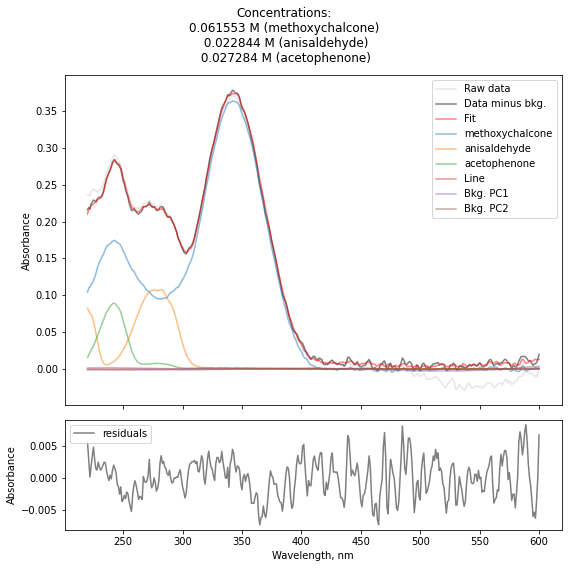

In [81]:
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax = ax1
ax.plot(wavelengths, target_spectrum_raw, label='Raw data', color='grey', alpha=0.2)
ax.plot(wavelengths, target_spectrum, label='Data minus bkg.', color='black', alpha=0.5)
ax.plot(wavelengths, model_function(wavelength_indices, *popt), color='r', label='Fit', alpha=0.5)
for calibrant_index in range(len(calibrant_shortnames)):
    cpopt = [x if i == calibrant_index else 0 for i, x in enumerate(popt)]
    ax.plot(wavelengths, model_function(wavelength_indices, *cpopt), label=calibrant_shortnames[calibrant_index], alpha=0.5)
if use_line:
    cpopt = [x if i == len(popt) - 3 else 0 for i, x in enumerate(popt)]
    ax.plot(wavelengths, model_function(wavelength_indices, *cpopt), label='Line', alpha=0.5)
if not ignore_pca_bkg:
    cpopt = [x if i == len(popt) - 2 else 0 for i, x in enumerate(popt)]
    ax.plot(wavelengths, model_function(wavelength_indices, *cpopt), label='Bkg. PC1', alpha=0.5)
    cpopt = [x if i == len(popt) - 1 else 0 for i, x in enumerate(popt)]
    ax.plot(wavelengths, model_function(wavelength_indices, *cpopt), label='Bkg. PC2', alpha=0.5)

title_str = f'Concentrations:\n'
for i in range(len(concentrations_here)):
    title_str += f'{np.array(concentrations_here)[i]:.6f} M ({calibrant_shortnames[i]})\n '
fig1.suptitle(title_str[:-2])
ax.set_ylabel('Absorbance')
ax.legend()
ax = ax2
ax.plot(wavelengths, target_spectrum - model_function(wavelength_indices, *popt), color='black', alpha=0.5,
        label='residuals')
ax.legend()
ax.set_xlabel('Wavelength, nm')
ax.set_ylabel('Absorbance')

plt.tight_layout()
plt.show()

---

# Chapter 2: Achieving the same results by using high-level functions from our code repository

The step-by-step approach shown above demonstrates the underlying methodology, but in practice, we can achieve the same results more concisely using the modules we build in this repository.

## Streamlined Calibration with "perform_calibration()" method

The `robowski.uv_vis_absorption_spectroscopy.calibrator.perform_calibration()` function automates the entire calibration workflow. First, we import the needed functions:

In [82]:
import robowski.uv_vis_absorption_spectroscopy.calibrator as calibrator
import robowski.uv_vis_absorption_spectroscopy.process_wellplate_spectra as process_wellplate_spectra
import robowski.uv_vis_absorption_spectroscopy.examples.versatility.versatility_examples as versatility_examples

These paths are going to be used to locate the calibration data and to store the calibration results. We set the `data_folder` to an empty string '' so that we can use relative paths in this example, as the relative paths are used in the rest of this notebook

In [83]:
experiment_name = 'data/'
calibration_source_filename = 'calibration_of_all_components'

# setting the data_folder to '' so that we can use relative paths as in the rest of this notebook
calibrator.data_folder = ''
versatility_examples.data_folder = ''
process_wellplate_spectra.data_folder = ''

Then we perform calibration. Because after each call to `perform_calibration()` the calibration data is saved to a file, it is not necessary to calibrate all the components in a single call to this function. We can call this function multiple times to calibrate different components in different calls. In the example below, we first perform calibration for methoxychalcone, then for anisaldehyde and acetophenone. If you want to see the calibration plots, set the `do_plot` variable to `True`. Once the calibration is complete, the calibration results will be saved in the folder `experiment_name + 'microspectrometer_data/calibration/'`.

In [84]:
do_plot = False
# Calibrate methoxychalcone
calibrator.perform_calibration(
    cut_from=5,
    lower_limit_of_absorbance=0.007,
    concentration_column_name='concentration',
    do_plot=do_plot,
    calibration_source_filename=calibration_source_filename,
    calibrant_shortnames=['methoxychalcone'],
    ref_concentrations=[0.0002],
    max_concentrations=[0.0006],
    experiment_name=experiment_name,
    upper_limit_of_absorbance=1e6,
    artefactogenic_upper_limit_of_absorbance=1e6,
    do_smoothing_at_low_absorbance=None
)

# Calibrate anisaldehyde and acetophenone. 
calibrator.perform_calibration(
    cut_from=5,
    lower_limit_of_absorbance=0.007,
    concentration_column_name='concentration',
    do_plot=do_plot,
    calibration_source_filename=calibration_source_filename,
    calibrant_shortnames=['anisaldehyde', 'acetophenone'],
    ref_concentrations=[0.0002, 0.0003],
    max_concentrations=[0.001, 0.001],
    experiment_name=experiment_name,
    upper_limit_of_absorbance=1e6,
    artefactogenic_upper_limit_of_absorbance=1e6,
    do_smoothing_at_low_absorbance=None
)

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

## Streamlined unmixing with "spectrum_to_concentration()" method

Once the calibration has been performed and its results saved to files, spectral unmixing can be performed using the `spectrum_to_concentration()` method as follows

### Creating the SpectraProcessor object and performing the unmixing

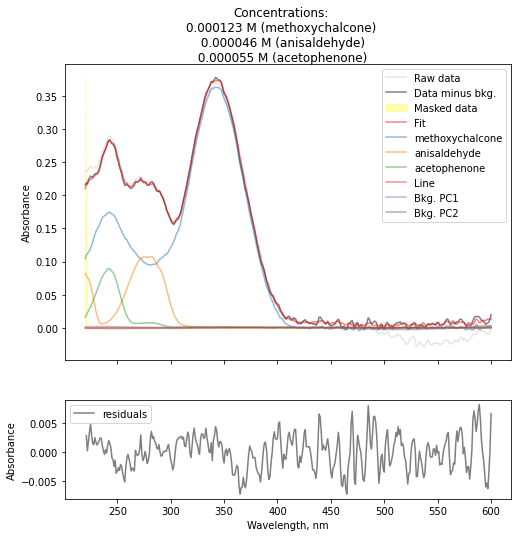

In [85]:
# Initialization of the SpectraProcessor object
sp = process_wellplate_spectra.SpectraProcessor(
    folder_with_correction_dataset=process_wellplate_spectra.repo_data_path + 'uv_vis_absorption_spectroscopy/microspectrometer-calibration/'
                                   '2022-12-01/interpolator-dataset/',
    filepath_of_csv_stoichiometry_table=None)
sp.nanodrop_lower_cutoff_of_wavelengths = 220

# This is the folder where the calibration results were stored in the previous step
process_wellplate_spectra.create_folder_unless_it_exists(experiment_name + 'results')
process_wellplate_spectra.create_folder_unless_it_exists(experiment_name + 'results/uv-vis-fits')
concentrations_here, concentration_errors = sp.spectrum_to_concentration(target_spectrum_input=target_spectrum_raw,
                                                     calibration_folder=experiment_name + 'microspectrometer_data/calibration/',
                                                     calibrant_shortnames=calibrant_shortnames,
                                                     fig_filename=experiment_name + f'results/uv-vis-fits/sample_{sample_id}',
                                                     do_plot=True, # whether to show the plot to the user
                                                     background_model_folder=background_model_folder,
                                                     upper_bounds=[np.inf] * 3,
                                                     cut_from=0, # this means that the fitting will not cut the spectrum from the left (blue end)
                                                     cut_to=False, # this means that the fitting will not cut the spectrum from the right (red end)
                                                     ignore_abs_threshold=True,
                                                     ignore_pca_bkg=ignore_pca_bkg,
                                                     use_line=use_line,
                                                     return_errors=True)

### Accounting for the dilution factor and printing the concentrations of the crude before dilution

As before, we need to account for the dilution factor of the crude mixture. The `spectrum_to_concentration()` method does not know about the dilution factor, so we apply it manually.

In [86]:
# Applying the dilution factor
concentrations_here = [conc * dilution_factor_of_the_crude_mixture for conc in concentrations_here]
concentration_errors = [err * dilution_factor_of_the_crude_mixture for err in concentration_errors]

# Print concentration in a nicely formatted way
print("Concentrations of the components in the target spectrum (computed by the high-level methods):")
for i, conc in enumerate(concentrations_here):
    print(f"{calibrant_shortnames[i]}: concentration {conc:.6f} mol/L ± {concentration_errors[i]:.6f} mol/L "
          f"(fitted coefficient: {popt[i]:.6f} ± {perr[i]:.6f})")

Concentrations of the components in the target spectrum (computed by the high-level methods):
methoxychalcone: concentration 0.061558 mol/L ± 0.000137 mol/L (fitted coefficient: 0.609941 ± 0.001389)
anisaldehyde: concentration 0.022851 mol/L ± 0.000174 mol/L (fitted coefficient: 0.246278 ± 0.001874)
acetophenone: concentration 0.027306 mol/L ± 0.000285 mol/L (fitted coefficient: 0.169812 ± 0.001864)


### Obtaining the fitting quality metrics

It is also possible to obtain various metrics produced by the spectral unmixing process by setting `return_report` parameter to `True`, and remove `return_errors=True`. Then the second element of the tuple returned by the `spectrum_to_concentration()` method will be a dictionary containing the following keys:
 - `concentration_errors`: errors of concentration (in the same units as the concentrations in the calibration data)
 - `rmse` : root-mean squared error of the fit (in same absorbance units as the spectrum itself)
 - `dw_statistic` : Durbin-Watson statistic (closet to 2 is better). It is computed with a lag equal to 30 nm.
 - `LB_stat` : Ljung-Box statistic (smaller is better)
 - `LB_pvalue` : Ljung-Box p-value (often to small to be meaningful, due to the non-zero autocorrelation of the instrumental noise).

In [88]:
concentrations_here, report = sp.spectrum_to_concentration(target_spectrum_input=target_spectrum_raw,
                                                     calibration_folder=experiment_name + 'microspectrometer_data/calibration/',
                                                     calibrant_shortnames=calibrant_shortnames,
                                                     fig_filename=experiment_name + f'results/uv-vis-fits/sample_{sample_id}',
                                                     do_plot=False, # whether to show the plot to the user
                                                     background_model_folder=background_model_folder,
                                                     upper_bounds=[np.inf] * 3,
                                                     cut_from=0, # this means that the fitting will not cut the spectrum from the left (blue end)
                                                     cut_to=False, # this means that the fitting will not cut the spectrum from the right (red end)
                                                     ignore_abs_threshold=True,
                                                     ignore_pca_bkg=ignore_pca_bkg,
                                                     use_line=use_line,
                                                     return_report=True)
# Print the quality metrics from the report: rmse, LB_stat, LB_pvalue
print("Fitting quality metrics:")
print(f"Root-mean squared difference between the fitted and experimental spectra: {report['rmse']:.6f} (in same units as the spectrum)")
print(f"Durbin-Watson autocorrelation statistic at lag 30 nm: {report['dw_statistic']}")
print(f"Ljung-Box autocorrelation statistic: {report['LB_stat']}")
print(f"Ljung-Box autocorrelation p-value: {report['LB_pvalue']}")

Fitting quality metrics:
Root-mean squared difference between the fitted and experimental spectra: 0.002963 (in same units as the spectrum)
Durbin-Watson autocorrelation statistic at lag 30 nm: 3.055573163765011
Ljung-Box autocorrelation statistic: 766.4326306359872
Ljung-Box autocorrelation p-value: 1.1585717619028508e-114


<Figure size 432x288 with 0 Axes>